In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
import json
import os

In [2]:
%cd ..

f:\ProjectSolar\ProjectSolar-20240704_v0


In [3]:
with open('config.json', 'r') as file:
    CONFIG = json.load(file)

In [4]:
folder_path = CONFIG['study_area']['data_root']
data_root = os.path.join(folder_path, CONFIG['output_folder_name'])
point_grid_path = os.path.join(data_root, 'intermediate', 'point_grid.dat')
index_map_path = os.path.join(data_root,  'index_map.dat')
shadow_map_path = os.path.join(data_root, 'shadow_map.dat')


horizon_factor_path = os.path.join(data_root, 'horizon_factor_map.dat')
sky_view_factor_path = os.path.join(data_root,  'sky_view_factor_map.dat')
cosine_map_path = os.path.join(data_root, 'cosine_map.dat')

voxel_size = CONFIG['voxel_resolution']
num_azimuth = 360//CONFIG['azimuth_resolution']
num_elevation = 90//CONFIG['elevation_resolution']
print(num_azimuth, num_elevation)
num_samples = num_azimuth*num_elevation
index_dim = (num_elevation,num_azimuth)

estimated_irradiance_path = os.path.join(data_root, 'irradiance.npy')
weather_data_path = os.path.join(data_root, 'weather_data.npy')

180 45


In [5]:
point_grid = np.loadtxt(point_grid_path)
estimated_irradiance = np.load(estimated_irradiance_path)
weather_data = np.load(weather_data_path)

In [6]:
estimated_irradiance.shape

(2, 720505, 8)

In [7]:
weather_data.shape

(8, 3)

In [8]:
point_grid.shape

(720505, 9)

In [9]:
def print_point_info(point_grid, horizon_factor_path, sky_view_factor_path, index_map_path, cosine_map_path, index_dim, point_idx):
    horizon_factor_path = np.memmap(horizon_factor_path, dtype=np.float16, mode='r')
    sky_view_factor_path = np.memmap(sky_view_factor_path, dtype=np.int32, mode='r')
    index_map = np.memmap(index_map_path, dtype=np.uint32, mode='r')
    cosine_map = np.memmap(cosine_map_path, dtype=np.float16, mode='r')

    num_samples = index_dim[0]*index_dim[1]
    index_start = point_idx*num_samples
    index_end = (point_idx+1)*num_samples

    voxel_indices = index_map[index_start:index_end]
    # breakpoint()
    voxel_indices = voxel_indices.reshape(index_dim)
    unique_values = np.unique(voxel_indices)

    sum_of_cosine = np.sum(cosine_map[index_start*6:index_end*6])
    print("sum of cosine: ", sum_of_cosine)

    # 创建一个随机颜色映射，确保白色为最大值对应的颜色
    colors = {}
    for value in unique_values:
        # print(value)
        if value == 4294967295:
            colors[value] = (1.0, 1.0, 1.0)  # 白色
        else:
            colors[value] = (random.random(), random.random(), random.random())

    # 将图像数据转换为 RGB
    image = np.zeros((voxel_indices.shape[0], voxel_indices.shape[1], 3))

    for i in range(voxel_indices.shape[0]):
        for j in range(voxel_indices.shape[1]):
            image[i, j] = colors[voxel_indices[i, j]]

    image = np.flipud(image)
    plt.imshow(image)
    plt.axis('off')  # 隐藏坐标轴
    plt.show()

    print("sky view factor: ", sky_view_factor_path[point_idx]/num_samples)
    print("horizon factor: ", horizon_factor_path[point_idx])
    formatted_values = [f"{x:.5f}" for x in point_grid[point_idx]]
    print("point info: ", formatted_values)

In [10]:
index_dim[0]*index_dim[1]

8100

sum of cosine:  255.2


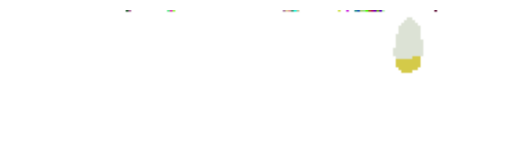

sky view factor:  0.9766666666666667
horizon factor:  nan
point info:  ['214284.00000', '494443.00000', '5.05800', '0.00000', '0.00000', '1.00000', '0.10000', '1.00000', '720495.00000']


In [16]:
# idx= 740955 # weatherstation
idx = 720495 # random
print_point_info(point_grid, horizon_factor_path, sky_view_factor_path, index_map_path, cosine_map_path, index_dim, idx)

In [17]:
estimated_irradiance[0][idx]

array([ 41.95188882,  96.05195686, 124.20901325, 130.39547534,
       114.72621285,  71.01459846,  21.7206663 ,   1.95333338])

In [18]:
estimated_irradiance[1][idx]

array([ 45.53529664,  98.65483249, 126.08466649, 131.77183074,
       115.625626  ,  71.58932641,  21.91011207,   1.97106295])

In [19]:
weather_data[:,0]

array([ 68, 110, 133, 134, 114,  70,  22,   2], dtype=int64)